In [ ]:
import matplotlib
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from scipy.ndimage.filters import gaussian_filter
import random
from glob import glob
from radam import RAdam

import torch
from torch.nn import Linear
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import SGD, Adam, RMSprop
from torch.autograd import Variable, grad
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler

from mpl_toolkits.mplot3d import Axes3D

import apex.amp as amp
import sys
import skfmm

# Dataset Definition

Selecting random source reciever locations from across the volume. $Xp$ represents a vector of source and reciever locations in form $[Xs,Ys,Zs,Xr,Yr,Zr]$. $Yp$ represents the velocity at the reciever locations. As this is a homogenous model all velocity values are $0.5km/s$

In [2]:
def randPoints(numsamples=10000,dist=None):
    # Increasing the number of points to allow for possible mismatc h
    X  = np.random.rand(numsamples,6)*2
    return X


def CreateDataset(PATH,create=False,Numsamples=5000,PointDistance=None):
    if create == True:
        Xp = randPoints(numsamples=Numsamples,dist=PointDistance)

        Yp  = np.ones(Xp.shape[0])*0.5

        # Saving the training dataset
        np.save('{}/Xp'.format(PATH),Xp)
        np.save('{}/Yp'.format(PATH),Yp)
    else:
        try:
            Xp = np.load('{}/Xp.npy'.format(PATH))
            Yp = np.load('{}/Yp.npy'.format(PATH))
        except ValueError:
            print('Please specify a correct source path, or create a dataset')

    return Xp,Yp

# Neural Network Achietecture


In [3]:
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        # Defining the neural network
        self.relu = torch.nn.ReLU()
        
        # Layers 
        self.fc0  = Linear(2*3,32)
        self.fc1  = Linear(32,512)

        # resnet - block 1
        self.rn1_fc1  = Linear(512,512)
        self.rn1_fc2  = Linear(512,512)
        self.rn1_fc3  = Linear(512,512)

        # resnet - block 2 
        self.rn2_fc1  = Linear(512,512)
        self.rn2_fc2  = Linear(512,512)
        self.rn2_fc3  = Linear(512,512)

        # resnet - block 2 
        self.rn3_fc1  = Linear(512,512)
        self.rn3_fc2  = Linear(512,512)
        self.rn3_fc3  = Linear(512,512)

        # resnet - block 2 
        self.rn4_fc1  = Linear(512,512)
        self.rn4_fc2  = Linear(512,512)
        self.rn4_fc3  = Linear(512,512)

        # resnet - block 2 
        self.rn5_fc1  = Linear(512,512)
        self.rn5_fc2  = Linear(512,512)
        self.rn5_fc3  = Linear(512,512)

        # resnet - block 2 
        self.rn6_fc1  = Linear(512,512)
        self.rn6_fc2  = Linear(512,512)
        self.rn6_fc3  = Linear(512,512)

        # resnet - block 2 
        self.rn7_fc1  = Linear(512,512)
        self.rn7_fc2  = Linear(512,512)
        self.rn7_fc3  = Linear(512,512)

        # resnet - block 2 
        self.rn8_fc1  = Linear(512,512)
        self.rn8_fc2  = Linear(512,512)
        self.rn8_fc3  = Linear(512,512)

                # resnet - block 2 
        self.rn9_fc1  = Linear(512,512)
        self.rn9_fc2  = Linear(512,512)
        self.rn9_fc3  = Linear(512,512)

        # resnet - block 2 
        self.rn10_fc1  = Linear(512,512)
        self.rn10_fc2  = Linear(512,512)
        self.rn10_fc3  = Linear(512,512)


        # Output structure
        self.fc8  = Linear(512,32)
        self.fc9  = Linear(32,1)

    def forward(self, x):
        '''
         ============= Neural Network Structure ============
            INPUTS:  [Xs,Ys,Zs,Xr,Yr,Zr] - Shape (1x6)
                   Xs,Ys,Zs  -- the X,Y,Z location 
                   of the first point defined the source
                   Xr,Yr,Zr  -- the X,Y,Z location 
                   of the second point defined the reciever
                   
                   
            OUTPUTS: [Tsr,Trs,Tss,Trr] - Shape (1x4)
                     Tsr - Travel-time to reciever from source
                    
                     dT - [dT_sr_s,dT_sr_r] - Shape (1x2)
                     dT_sr_s - gradient of Tsr with respect to source   ([Xs,Ys,Zs]) - shape (1x3)
                     dT_sr_r - gradient of Tsr with respect to reciever ([Xr,Yr,Zr]) - shape (1x3)
        '''
        
        xor = x
        x   = self.relu(self.fc0(x))
        x   = self.relu(self.fc1(x))

        # Resnet - Block 1
        x0  = x
        x   = self.relu(self.rn1_fc1(x))
        x   = self.relu(self.rn1_fc3(x) + self.rn1_fc2(x0))


        # Resnet - Block 2
        x0  = x
        x   = self.relu(self.rn2_fc1(x))
        x   = self.relu(self.rn2_fc3(x)+self.rn2_fc2(x0))

        # Resnet - Block 3
        x0  = x
        x   = self.relu(self.rn3_fc1(x))
        x   = self.relu(self.rn3_fc3(x)+self.rn3_fc2(x0))

        # Resnet - Block 4
        x0  = x
        x   = self.relu(self.rn4_fc1(x))
        x   = self.relu(self.rn4_fc3(x)+self.rn4_fc2(x0))

        # Resnet - Block 5
        x0  = x
        x   = self.relu(self.rn5_fc1(x))
        x   = self.relu(self.rn5_fc3(x)+self.rn5_fc2(x0))

        # Resnet - Block 6
        x0  = x
        x   = self.relu(self.rn6_fc1(x))
        x   = self.relu(self.rn6_fc3(x)+self.rn6_fc2(x0))

        # Resnet - Block 5
        x0  = x
        x   = self.relu(self.rn7_fc1(x))
        x   = self.relu(self.rn7_fc3(x)+self.rn7_fc2(x0))

        # Resnet - Block 5
        x0  = x
        x   = self.relu(self.rn8_fc1(x))
        x   = self.relu(self.rn8_fc3(x)+self.rn8_fc2(x0))

        # Resnet - Block 5
        x0  = x
        x   = self.relu(self.rn9_fc1(x))
        x   = self.relu(self.rn9_fc3(x)+self.rn9_fc2(x0))

        # Resnet - Block 5
        x0  = x
        x   = self.relu(self.rn10_fc1(x))
        x   = self.relu(self.rn10_fc3(x)+self.rn10_fc2(x0))


        # Joining two blocks
        x     = self.relu(self.fc8(x))
        tau   = abs(self.fc9(x))
        dtau, = torch.autograd.grad(outputs=tau, inputs=xor, grad_outputs=torch.ones(tau.size()).to(device), 
                                  only_inputs=True,create_graph=True,retain_graph=True)


        T0 = torch.sqrt(((xor[:,3]-xor[:,0])**2 + (xor[:,4]-xor[:,1])**2 + (xor[:,5]-xor[:,2])**2))
        T1 = (T0**2)*(dtau[:,3]**2 + dtau[:,4]**2 + dtau[:,5]**2)
        T2 = 2*tau[:,0]*(dtau[:,3]*(xor[:,3]-xor[:,0]) + dtau[:,4]*(xor[:,4]-xor[:,1]) + dtau[:,5]*(xor[:,5]-xor[:,2]))
        T3 = tau[:,0]**2
        S2 = (T1+T2+T3)
        V2 = torch.sqrt(1/S2)
        T  = T0*tau[:,0]

        return T, V2

In [4]:
class NumpyDataset(torch.utils.data.Dataset):

    def __init__(self, data, target, transform=None):
        # Creating identical pairs
        self.data    = Variable(Tensor(data))
        self.target  = Variable(Tensor(target))

    def send_device(self,device):
        self.data    = self.data.to(device)
        self.target  = self.target.to(device)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y, index

    def __len__(self):
        return self.data.shape[0]

def init_weights(m):
    if type(m) == torch.nn.Linear:
        stdv = (1. / math.sqrt(m.weight.size(1))/1.)*2
        m.weight.data.uniform_(-stdv,stdv)
        m.bias.data.uniform_(-stdv,stdv)

def EikonalLoss(Yobs,Ypred):
        diff  = abs(Yobs-Ypred)
        loss  = torch.mean((Yobs-Ypred)**2)
        return loss, diff
        

In [5]:
class Model():
    def __init__(self, network, optimizer,scheduler, model_path, model_name):
        self.network    = network
        self.optimizer  = optimizer
        self.model_path = model_path
        self.model_name = model_name
        self.scheduler  = scheduler

        self.total_train_loss = []
        self.total_val_loss   = []
        
    def train(self, dataset,n_epochs,ResampleBounds):
        from torch.autograd import Variable
        import time

        len_dataset         = len(dataset)
        n_batches           = int(len(dataset)/btsize + 1)
        training_start_time = time.time()

        # Sending the data to GPU
        dataset.send_device(device) 

        # --------- Splitting the dataset into training and validation -------
        indices            = list(range(int(len_dataset)))
        validation_idx     = np.random.choice(indices, size=int(len_dataset*(validation_per/100)), replace=False)
        train_idx          = list(set(indices) - set(validation_idx))
        validation_sampler = SubsetRandomSampler(validation_idx)
        train_sampler      = SubsetRandomSampler(train_idx)

        train_loader       = torch.utils.data.DataLoader(
            dataset,
            batch_size=btsize,
            sampler=train_sampler,
            )    
        validation_loader  = torch.utils.data.DataLoader(
            dataset,
            batch_size=btsize,
            sampler=validation_sampler,
        )    



        # Defining the initial weights to sample by
        weights = Tensor(torch.ones(len(dataset))).to(device)
        weights[validation_idx] = 0.0

        print("=======================================================================================")
        print("=======================================================================================")
        print("========================== Eikonal Solver - Training ==================================")
        print("=======================================================================================")
        print("=======================================================================================")
        print("        Num Epochs          = {}".format(n_epochs))
        print("        Num Batches         = {}".format(n_batches))
        print("=======================================================================================")

        for epoch in range(n_epochs):
            print_every           = 1
            start_time            = time.time()
            running_sample_count  = 0

            total_train_loss      = 0
            total_val_loss        = 0



            # --- Defining the weighting of the samples


            weights                 = torch.clamp(weights/weights.max(),ResampleBounds[0],ResampleBounds[1])
            weights[validation_idx] = 0.0
            train_sampler_wei       = WeightedRandomSampler(weights, len(weights), replacement=True)
            train_loader_wei        = torch.utils.data.DataLoader(
                                        dataset,
                                        batch_size=btsize,
                                        sampler=train_sampler_wei,
                                      )

            weights                 = Tensor(torch.zeros(len(dataset))).to(device)
            
            for i, data in enumerate(train_loader_wei, 0):
                #print('----------------- Epoch {} - Batch {} --------------------'.format(epoch,i))
                
                # Get inputs/outputs and wrap in variable object
                inputs, labels, indexbatch = data

                # Making sure input and labels are floats
                inputs.float()
                labels.float()
                
                # Setting so the inputs require a gradient
                inputs.requires_grad_()

                # Forward pass
                outputs,pred_labels = self.network(inputs)
                
                # Determining the loss from the system 
                loss_, wv  = EikonalLoss(labels,pred_labels)

                with amp.scale_loss(loss_, optimizer) as loss_value:
                  loss_value.backward()

                # Update parameters
                self.optimizer.step()
                self.optimizer.zero_grad()

                # Updating the weights
                weights[indexbatch] = wv

                del inputs, labels, indexbatch, outputs, pred_labels, loss_, wv



            # ----- Determining the Validation Loss -----
            for i, data_train in enumerate(train_loader, 0):
                inputs_train, labels_train, indexbatch_train = data_train
                inputs_train.requires_grad_()
                outputs_train,pred_labels_train = self.network(inputs_train)
                train_loss,wv               = EikonalLoss(labels_train,pred_labels_train)
                total_train_loss           += train_loss.item()
                del inputs_train, labels_train, indexbatch_train, outputs_train, pred_labels_train, train_loss, wv


            # ----- Determining the Training Loss -----
            for i, data_val in enumerate(validation_loader, 0):
                inputs_val, labels_val, indexbatch_val = data_val
                inputs_val.requires_grad_()
                outputs_val,pred_labels_val = self.network(inputs_val)
                val_loss,wv                 = EikonalLoss(labels_val,pred_labels_val)
                total_val_loss             += val_loss.item()
                del inputs_val, labels_val, indexbatch_val, outputs_val, pred_labels_val, val_loss, wv




            # Creating a running loss for both training and validation data
            total_val_loss   /= len(validation_loader)
            total_train_loss /= len(train_loader)
            self.total_train_loss.append(total_train_loss)
            self.total_val_loss.append(total_val_loss)
            self.scheduler.step(total_val_loss)

            del train_loader_wei,train_sampler_wei

            if (epoch+1) % 10 == 1:
                with torch.no_grad():
                    print("Epoch = {} -- Training loss = {:.4e} -- Validation loss = {:.4e}".format(epoch+1,total_train_loss,total_val_loss))

            if (epoch+1) % 200 == 1:
                with torch.no_grad():
                    torch.save({
                        'epoch':epoch,
                        'model_state_dict': self.network.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'train_loss': self.total_train_loss,
                        'val_loss': self.total_val_loss,
                        }, '{}/{}_{}_{}.pt'.format(self.model_path, self.model_name,str(epoch).zfill(5),total_val_loss))

In [ ]:
num_epochs         = 200
datatset_size      = 1e6
validation_per     = 10
btsize             = 752
GPUid              = 7
ResampleBounds    = [0.1,0.9]

# -------------------------------------------------------------------
PATH               = './OutputModels'
Xp,Yp              = CreateDataset(PATH,Numsamples=int(datatset_size),create=True)
dataset            = NumpyDataset(Xp,Yp)

# -------------------------------------------------------------------
device             = torch.device("cuda:{}".format(GPUid))

# --------- Defining the neural network -------
torch.cuda.set_device(device)
net = NN()
net.apply(init_weights)
net.float()
net.to(device)

# --------- Defining optimizer -------
optimizer  = torch.optim.Adam(net.parameters(),lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
net, optimizer = amp.initialize(net, optimizer, opt_level='O0')

# --------- Training Model -------
model = Model(net, optimizer,scheduler,model_path=PATH,model_name='Homogenous_Model')
model.train(dataset,num_epochs,ResampleBounds)

# Plotting

A series of script to load up the saved EikoNet model and compute the travel-time to series of reciver locations in the X-Z domain at $Y=1$, at $0.01km$ spacing, from some user defined source location. 

In [16]:
def load_checkpoint(filepath,device):
    '''
        Loading an instance of EikoNet from a saved .pt
    
    
        INPUTS:
            filepath - path to .pt file
            
        OUTPUTS:
            model - Eikonet Model
    '''
    
    
    checkpoint = torch.load(filepath)
    # Defining Neural Network
    net = NN().to(device)
    net.apply(init_weights)
    net.float()
    net.to(device)
    optimizer  = torch.optim.Adam(net.parameters())
    scheduler = []
    model = Model(net, optimizer,scheduler, model_path=filepath,model_name='')
    model.total_train_loss = checkpoint['train_loss']
    model.total_val_loss   = checkpoint['val_loss']

    model.network.load_state_dict(checkpoint['model_state_dict'])
    for parameter in model.network.parameters():
        parameter.requires_grad = False

    model.network.eval()
    return model


def Plotting(model,Xsrc):
    '''
        Plotting the travel-time to a grid of points in the X-Z domain at Y=1, at 0.01km spacing, from some user
        defined Xsrc location
        
        INPUTS:
            model - EikoNet Model to compute travel-times using
            Xsrc  - Source locations in form [Xsrc,Ysrc,Zsrc] 
        
        
        
    
    '''
    
    
    
    # Constructing a grid of points int the X-Z dimension to determine the travel-time from some user defined source location
    spc      = 0.01
    linsp    = (np.arange(0,1,spc) + spc/2)*2
    X,Y      = np.meshgrid(linsp,linsp)

    XP       = np.ones((len(X.flatten()),6))
    XP[:,:3] = Xsrc
    XP[:,3]  = X.flatten()
    XP[:,4]  = 1.
    XP[:,5]  = Y.flatten()

    # Determining the travel-time for the points
    XP = Variable(Tensor(XP)).to(device)
    XP.requires_grad_()
    tt,vv  = model.network(XP)


    # Determining the travel-time for the points
    TT = tt.to('cpu').data.numpy().reshape(X.shape)
    V  = vv.to('cpu').data.numpy().reshape(X.shape)

    
    
    # Making comparisons with skfmm travel-times
    p0=np.argmin(abs(linsp-0.4));p1=np.argmin(abs(linsp-0.8));p2=np.argmin(abs(linsp-1.2));p3=np.argmin(abs(linsp-1.6))
    Vobs = np.ones(X.shape)*0.5

    phi    = np.ones(X.shape)
    phi[np.argmin(abs(linsp-Xsrc[0])),np.argmin(abs(linsp-Xsrc[2]))] = -1
    TTobs = np.transpose(skfmm.travel_time(phi,Vobs,dx=spc*2))



    # --- Plotting the expected travel-time
    plt.clf();plt.close('all')
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(331)  
    quad1 = ax.pcolormesh(X,Y,Vobs,vmin=0.4,vmax=0.6)
    ax.contour(X,Y,TTobs,np.arange(0,6,0.3),colors='w')
    plt.colorbar(quad1,ax=ax, orientation="horizontal", pad=0.1, label='Travel-Time')
    ax.set_aspect('equal')
    ax.set_title('1D Travel=-time')
    ax.set_ylabel('Y location')
    ax.set_xlabel('X location')
    ax.set_xlim([0.,2.])
    ax.set_ylim([0.,2.])


    ax = fig.add_subplot(332)  
    quad1 = ax.pcolormesh(X,Y,V,vmin=0.4,vmax=0.6)
    plt.colorbar(quad1,ax=ax, orientation="horizontal", pad=0.1, label='Obs Velocity')
    ax.set_title('Recovered Velocity')
    ax.contour(X,Y,TT,np.arange(0,6,0.3),colors='w')
    ax.set_aspect('equal')
    ax.set_ylabel('Y location')
    ax.set_xlabel('X location')
    ax.set_xlim([0.,2.])
    ax.set_ylim([0.,2.])

    ax = fig.add_subplot(333)  
    quad1 = ax.pcolormesh(X,Y,((V-Vobs)/Vobs)*100,cmap='bwr',vmin=-20.,vmax=20)
    plt.colorbar(quad1,ax=ax, orientation="horizontal", pad=0.1, label='Pred Velocity')
    ax.set_title('Percentage Difference')
    ax.contour(X,Y,Vobs,colors='k',linewidths=0.1)
    ax.set_aspect('equal')
    ax.set_ylabel('Y location')
    ax.set_xlabel('X location')
    ax.set_xlim([0.,2.])
    ax.set_ylim([0.,2.])





    # ================= Computing the expected travel-time and grads ===================
    spc      = 0.01
    linsp    = (np.arange(0,1,spc) + spc/2)*2
    X,Y      = np.meshgrid(linsp,linsp)

    XP       = np.ones((len(X.flatten()),6))
    XP[:,:3] = Xsrc
    XP[:,3]  = X.flatten()
    XP[:,4]  = Y.flatten()
    XP[:,5]  = 1.


    # Determining the travel-time for the points
    XP = Variable(Tensor(XP)).to(device)
    XP.requires_grad_()
    tt,vv  = model.network(XP)


    # Determining the travel-time for the points
    TT = tt.to('cpu').data.numpy().reshape(X.shape)
    V  = vv.to('cpu').data.numpy().reshape(X.shape)

    p0=np.argmin(abs(linsp-0.4));p1=np.argmin(abs(linsp-0.8));p2=np.argmin(abs(linsp-1.2));p3=np.argmin(abs(linsp-1.6))
    Vobs = np.ones(X.shape)*0.5

    Xm,Ym,Zm  = np.meshgrid(linsp,linsp,linsp)
    phi       = np.ones(Xm.shape)
    Vobs_3d   =  0.5*np.ones(phi.shape)
    phi[np.argmin(abs(linsp-Xsrc[0])),np.argmin(abs(linsp-Xsrc[1])),np.argmin(abs(linsp-Xsrc[2]))] = -1
    TTobs = skfmm.travel_time(phi,Vobs_3d,dx=spc*2)
    TTobs = TTobs[:,:,np.argmin(abs(linsp-1.))]
    del Vobs_3d,Xm,Ym,Zm,phi


    ax = fig.add_subplot(334)  
    quad1 = ax.pcolormesh(X,Y,Vobs,vmin=0.4,vmax=0.6)
    ax.contour(X,Y,TTobs,np.arange(0,6,0.3),colors='w')
    plt.colorbar(quad1,ax=ax, orientation="horizontal", pad=0.1, label='Travel-Time')
    ax.set_aspect('equal')
    ax.set_title('1D Travel=-time')
    ax.set_ylabel('Y location')
    ax.set_xlabel('X location')
    ax.set_xlim([0.,2.])
    ax.set_ylim([0.,2.])

    ax = fig.add_subplot(335)  
    quad1 = ax.pcolormesh(X,Y,V,vmin=0.4,vmax=0.6)
    plt.colorbar(quad1,ax=ax, orientation="horizontal", pad=0.1, label='Obs Velocity')
    ax.set_title('Recoverd Velocity')
    ax.contour(X,Y,TT,np.arange(0,6,0.3),colors='w')
    ax.set_aspect('equal')
    ax.set_ylabel('Y location')
    ax.set_xlabel('X location')
    ax.set_xlim([0.,2.])
    ax.set_ylim([0.,2.])

    ax = fig.add_subplot(336)  
    quad1 = ax.pcolormesh(X,Y,((V-Vobs)/Vobs)*100,cmap='bwr',vmin=-20.,vmax=20.)
    plt.colorbar(quad1,ax=ax, orientation="horizontal", pad=0.1, label='Pred Velocity')
    ax.contour(X,Y,Vobs,colors='k',linewidths=0.1)
    ax.set_title('Percentage Difference')
    ax.set_aspect('equal')
    ax.set_ylabel('Y location')
    ax.set_xlabel('X location')
    ax.set_xlim([0.,2.])
    ax.set_ylim([0.,2.])


    # -- Plotting the training loss 
    ax  = fig.add_subplot(325)
    ax.set_title('Loss Terms')

    ax.plot(np.arange(len(model.total_train_loss))+1,model.total_train_loss,'r',label='Training-Loss')
    ax.set_xlim([1,len(np.arange(len(model.total_train_loss))+1)])
    ax.set_ylabel('Training Loss')
    ax.set_xlabel('Epoch')
    ax.set_yscale('log')
    ax.plot(np.arange(len(model.total_train_loss))+1,model.total_val_loss,'k',label='Validation-Loss')
    ax.set_yscale('log')
    ax.legend(loc=0)
    ax.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Training-Loss ={}, Validation-Loss={}\n'.format(model.total_train_loss[-1],model.total_val_loss[-1]))

    return fig

/home/jsmith/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: UserWarning: No contour levels were found within the data range.
/home/jsmith/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: UserWarning: No contour levels were found within the data range.
/home/jsmith/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:206: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


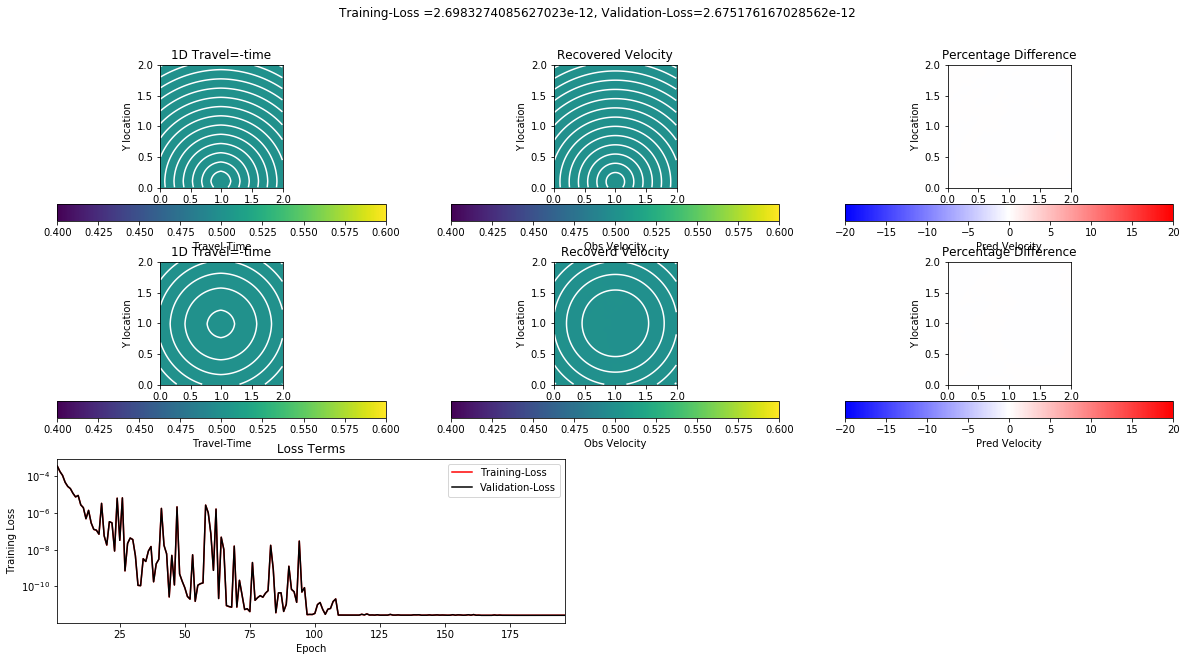

In [17]:
fname = './OutputModels/Homogeneous_00195_2.675176167028562e-12.pt'
md    = load_checkpoint(fname,device)
fig   = Plotting(md,[1.0,1.,0.1])
plt.show()